In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


# Show all rows in output
pd.set_option('display.max_rows', 10)
# Show all columns in output
pd.set_option('display.max_columns', 200)

In [2]:
merchants = pd.read_csv(r'../Data/merchants.csv')
users = pd.read_csv(r'../Data/users.csv')
transactions = pd.read_json(r'../Data/transactions.json', lines=True, dtype_backend="numpy_nullable")

# Merge transaction with merchant info
df_combined = transactions.merge(merchants, on='merchant_id', how='left')
# Merge result with user info
df_combined = df_combined.merge(users, on='user_id', how='left')

In [3]:
df = df_combined

In [4]:
def get_part_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    elif 21 <= hour < 23:
        return 'night'
    else:
        return 'late_night'
    
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Distance in kilometers

def plot_time_diff_histogram(df, time_diff_col='time_diff', bins=50):
    """
    Plots a histogram of time differences between transactions.

    Parameters:
    - df: pandas DataFrame
    - time_diff_col: column name with time differences (in hours)
    - bins: number of histogram bins
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[time_diff_col].dropna(), bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Time Between Transactions (hours)')
    plt.ylabel('Number of Transactions')
    plt.title('Histogram of Time Between Transactions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_time_diff_histogram_trimmed(df, time_diff_col='time_diff', bins=50, 
                                     lower_quantile=0.0, upper_quantile=0.9):
    """
    Plots a histogram of time differences between transactions,
    trimmed to the specified quantile range. Supports timedelta or numeric input.

    Parameters:
    - df: pandas DataFrame
    - time_diff_col: name of the column with time differences
    - bins: number of bins
    - lower_quantile: minimum quantile (e.g. 0.05)
    - upper_quantile: maximum quantile (e.g. 0.95)
    """
    time_diffs = df[time_diff_col].dropna()

    # Convert timedelta to hours if necessary
    if pd.api.types.is_timedelta64_dtype(time_diffs):
        time_diffs = time_diffs.dt.total_seconds() / 3600

    # Trim to quantile range
    lower_limit = time_diffs.quantile(lower_quantile)
    upper_limit = time_diffs.quantile(upper_quantile)
    trimmed = time_diffs[(time_diffs >= lower_limit) & (time_diffs <= upper_limit)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(trimmed, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Time Between Transactions (hours)')
    plt.ylabel('Number of Transactions')
    plt.title(f'Histogram of Time Between Transactions\n({int(lower_quantile*100)}–{int(upper_quantile*100)}% Quantile)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
def data_transform(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['Month_Year_EOM'] = (df['timestamp'] + pd.offsets.MonthEnd(0)).dt.date
    df['Date'] = df['timestamp'].dt.strftime('%d-%m-%Y')
    df['Year'] = df['timestamp'].dt.strftime('%Y')
    df['hour'] = df['timestamp'].dt.hour
    df['part_of_day'] = df['hour'].apply(get_part_of_day)

    df = df.sort_values(['user_id', 'timestamp'])

    # Create the driver: time difference from previous timestamp per user
    df['time_diff'] = df.groupby('user_id')['timestamp'].diff()
    df['time_diff_hours'] = (df['time_diff'].dt.total_seconds() / 3600).round(2)
    df['latitude'] = df['location'].apply(lambda x: x.get('lat')).round(2)
    df['longitude'] = df['location'].apply(lambda x: x.get('long')).round(2)

    df = df.sort_values(['user_id', 'timestamp'])

    # Shift lat, lon, and timestamp within each user
    df['lat_prev'] = df.groupby('user_id')['latitude'].shift()
    df['lon_prev'] = df.groupby('user_id')['longitude'].shift()
    df['time_prev'] = df.groupby('user_id')['timestamp'].shift()

    # Calculate time difference in hours
    df['time_diff_hours'] = (df['timestamp'] - df['time_prev']).dt.total_seconds() / 3600

    # Calculate distance (only between consecutive positions of the same user)
    df['distance_km'] = haversine(df['lat_prev'], df['lon_prev'], df['latitude'], df['longitude'])

    # Optional: speed in km/h
    df['speed_kmph'] = df['distance_km'] / df['time_diff_hours']
    df['amount/avg_amount'] = df['amount'] / df['avg_transaction_amount']
    df['amount/sum_monthly_installments'] = df['amount'] / df['sum_of_monthly_installments']
    df['amount/sum_monthly_expenses'] = df['amount'] / df['sum_of_monthly_expenses']
    df['speed_kmph'] = df['speed_kmph'].clip(upper=2000)
    df['countries_same'] = (df['country_x'] == df['country_y']).astype(int)



    return df

In [6]:
df = data_transform(df)

In [7]:
# DELETE FIRST OBSERVATIONS
first_idx = df.sort_values(by=['user_id', 'timestamp']).groupby('user_id').head(1).index

# Drop those rows
df = df.drop(index=first_idx)

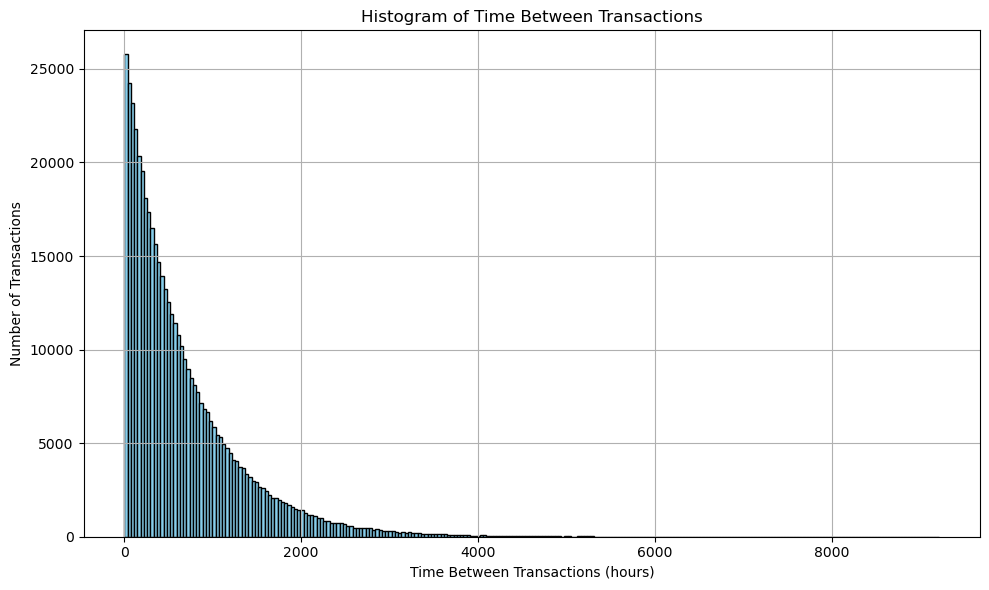

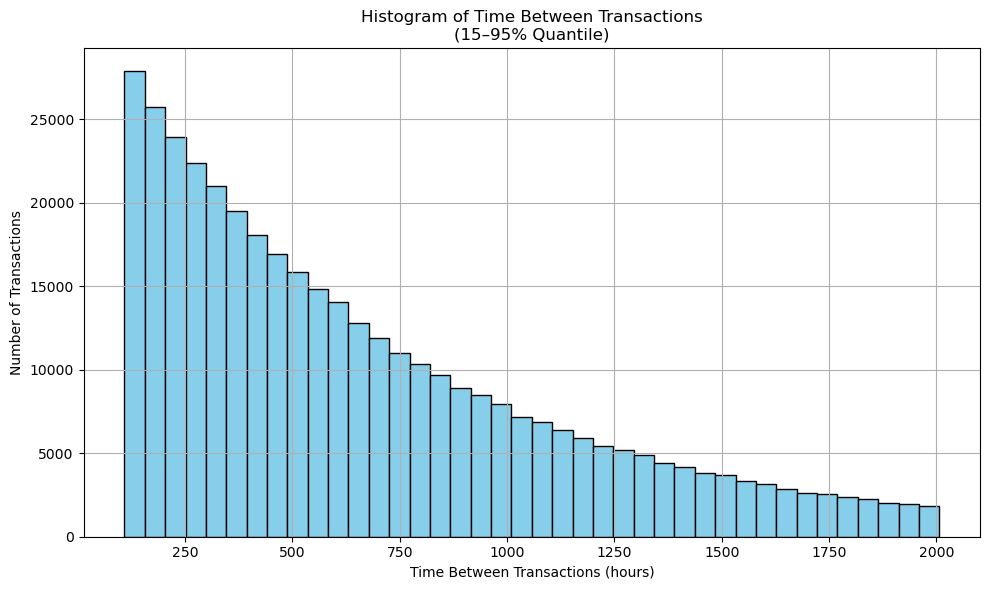

In [9]:
plot_time_diff_histogram(df, time_diff_col='time_diff_hours', bins=250)
plot_time_diff_histogram_trimmed(df, time_diff_col='time_diff', bins=40,
                                 lower_quantile=0.15, upper_quantile=0.95)



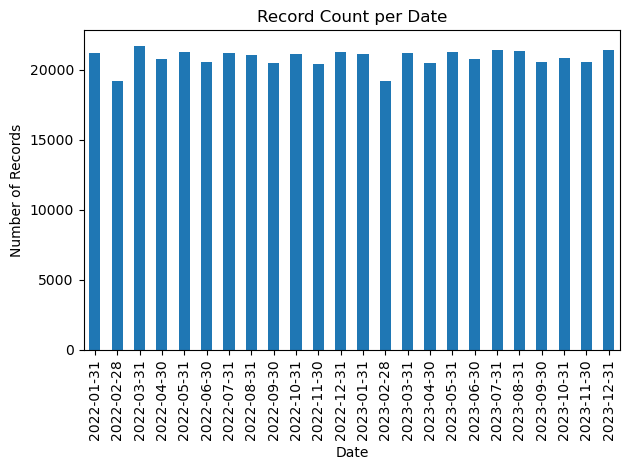

In [10]:
daily_counts = df.groupby('Month_Year_EOM').size()

# Plot
plt.xticks(rotation=90)
daily_counts.plot(kind='bar')  # or use 'line', 'area', etc.
plt.ylabel('Number of Records')
plt.xlabel('Date')
plt.title('Record Count per Date')
plt.tight_layout()
plt.show()

In [29]:

def calculate_bad_percentage_with_plot(df, feature, target):
    """
    Calculates bad rate per category and plots a side-by-side dual-axis bar chart:
    - Left Y-axis: % of records per category (gray background bars)
    - Right Y-axis: bad rate (colored overlay bars)

    Parameters:
    - df: pandas DataFrame
    - feature: categorical column name
    - target: binary column name (1 = bad, 0 = good)

    Returns:
    - summary DataFrame with total, bads, bad_rate, and percent columns
    """
    if feature not in df.columns or target not in df.columns:
        raise ValueError(f"Columns '{feature}' or '{target}' not found in DataFrame.")

    df = df.copy()

    # Aggregate totals and bads
    grouped = df.groupby(feature, observed=True)[target].agg(['count', 'sum']).reset_index()
    grouped.rename(columns={'count': 'total', 'sum': 'bads'}, inplace=True)
    grouped['bad_rate'] = grouped['bads'] / grouped['total']
    grouped['percent'] = grouped['total'] / grouped['total'].sum() * 100

    # Labels and x positions
    labels = grouped[feature].astype(str)
    x = np.arange(len(labels))  # numeric x locations
    width = 0.4

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar 1: % of records (left y-axis)
    bars1 = ax1.bar(x - width/2, grouped['percent'], width=width, color='gray', alpha=0.5, label='% of Records')
    ax1.set_ylabel('% of Records', color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # Bar 2: Bad rate (right y-axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, grouped['bad_rate'], width=width, color='tab:blue', alpha=0.7, label='Bad Rate')
    ax2.set_ylabel('Bad Rate', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Final formatting
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.set_xlabel(feature)
    plt.title(f'Bad Rate and % of Records by {feature}')
    fig.tight_layout()
    plt.show()

    return grouped

In [30]:
drivers = ['channel', 'currency', 'device', 'payment_method', 'is_international', 'is_first_time_merchant',
           'category', 'country_x', 'number_of_alerts_last_6_months', 'has_fraud_history', 'sex', 'education', 'primary_source_of_income',
           'country_y', 'hour', 'part_of_day', 'countries_same'
            ]


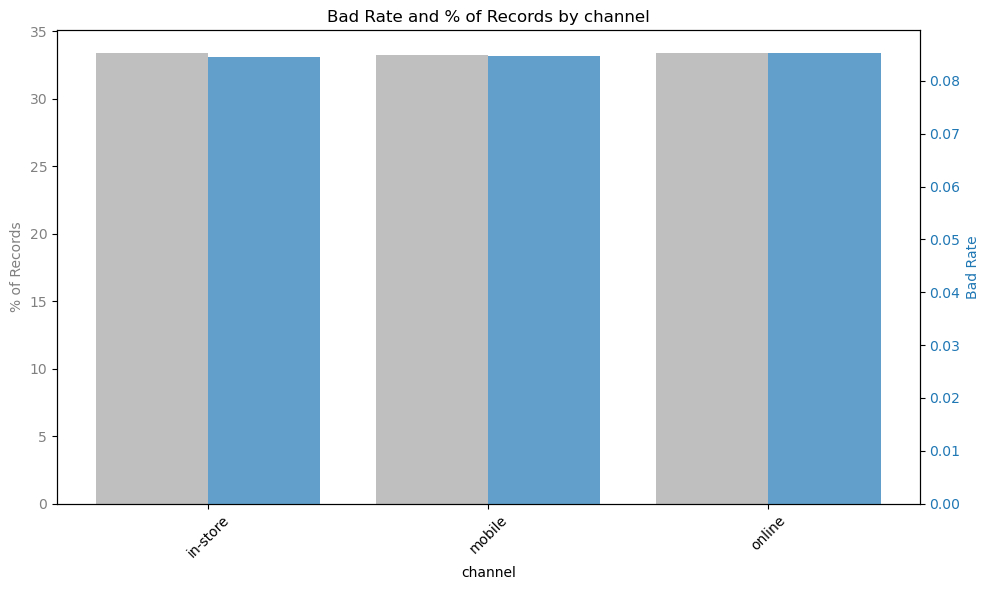

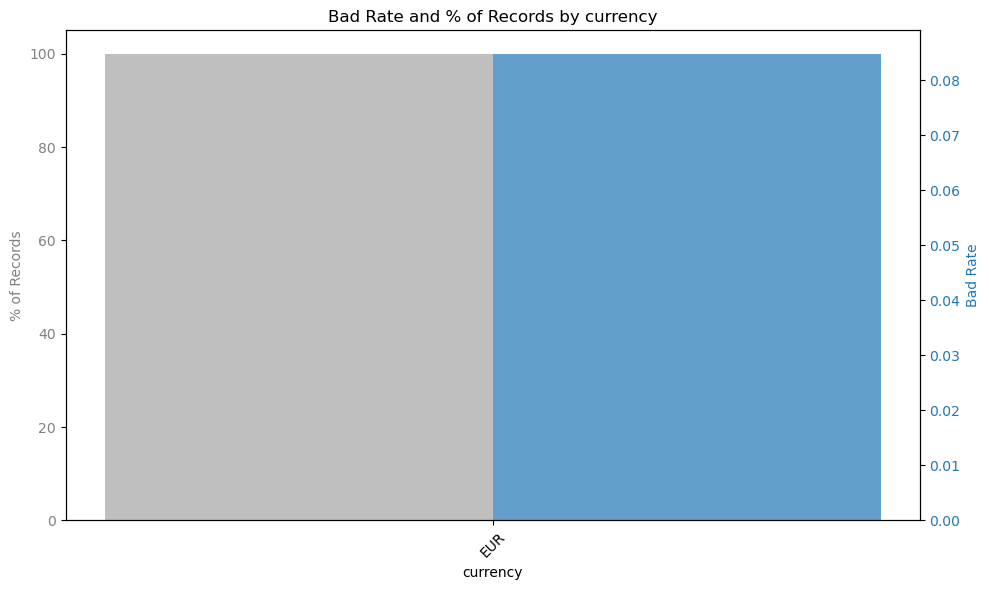

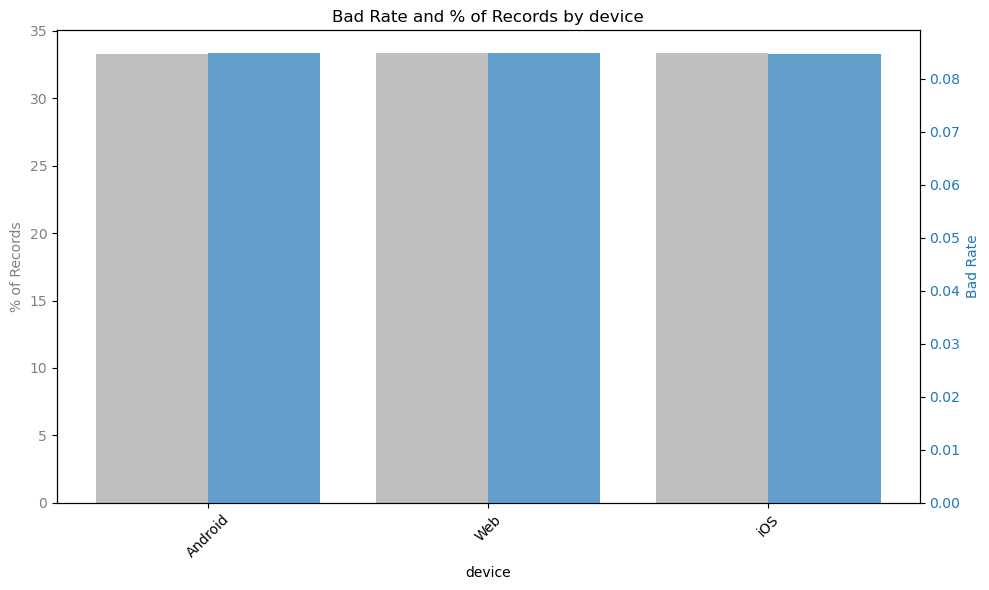

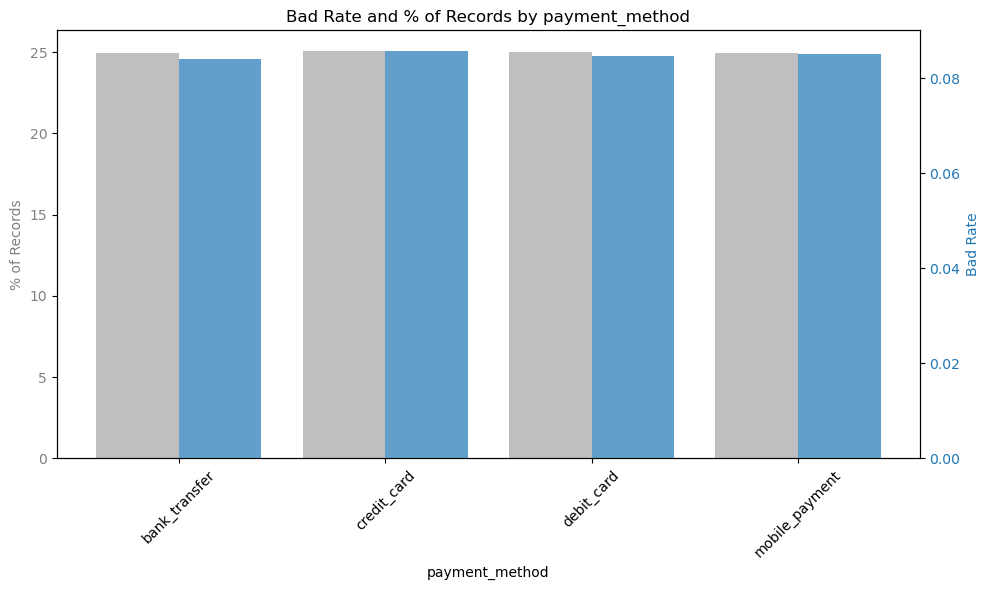

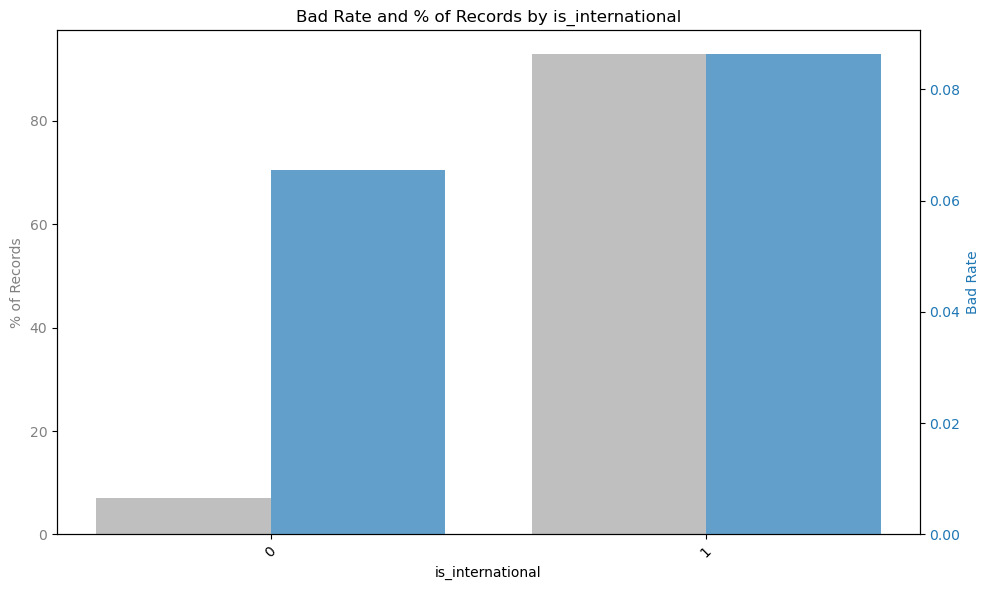

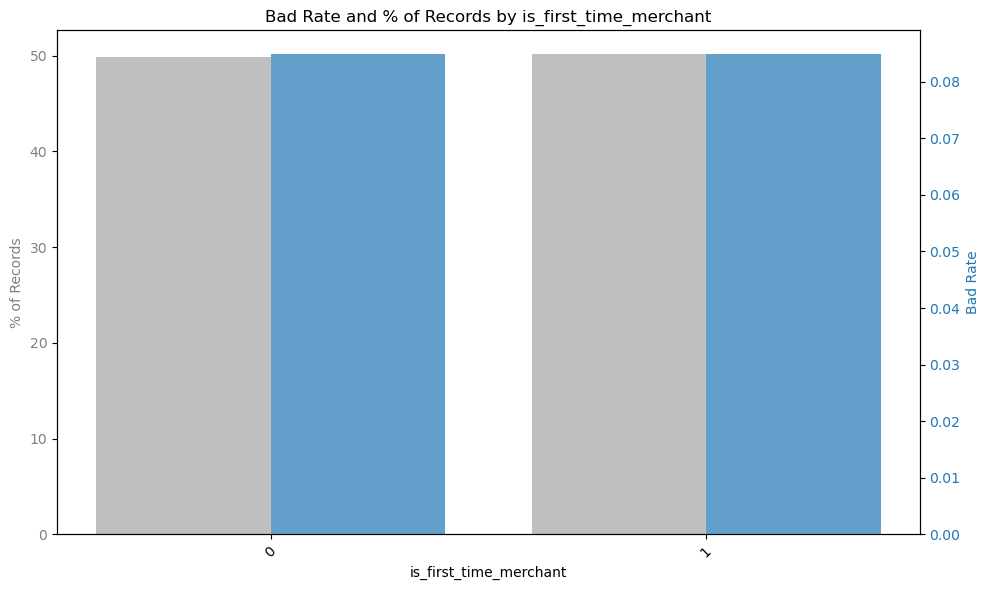

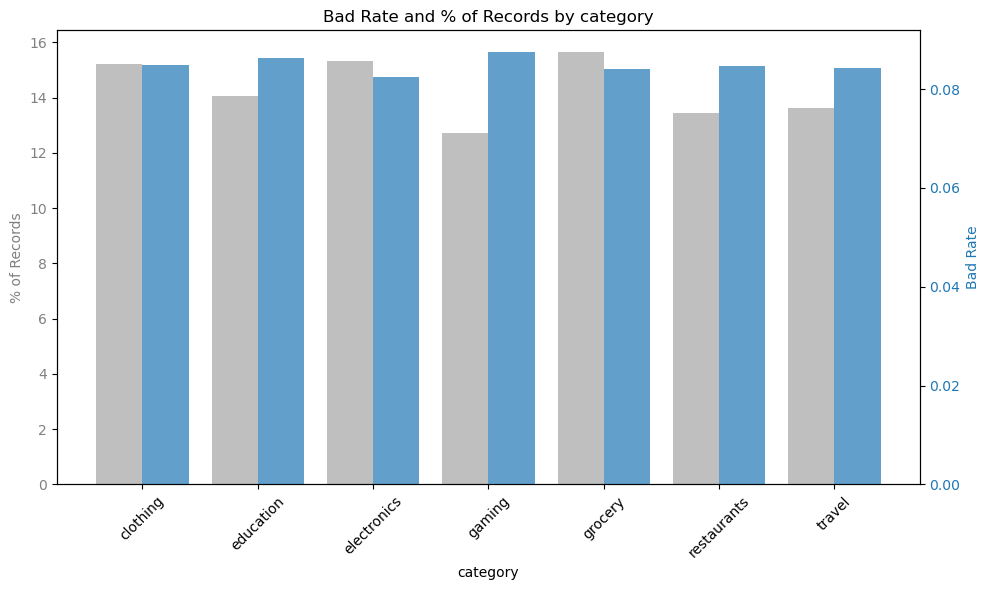

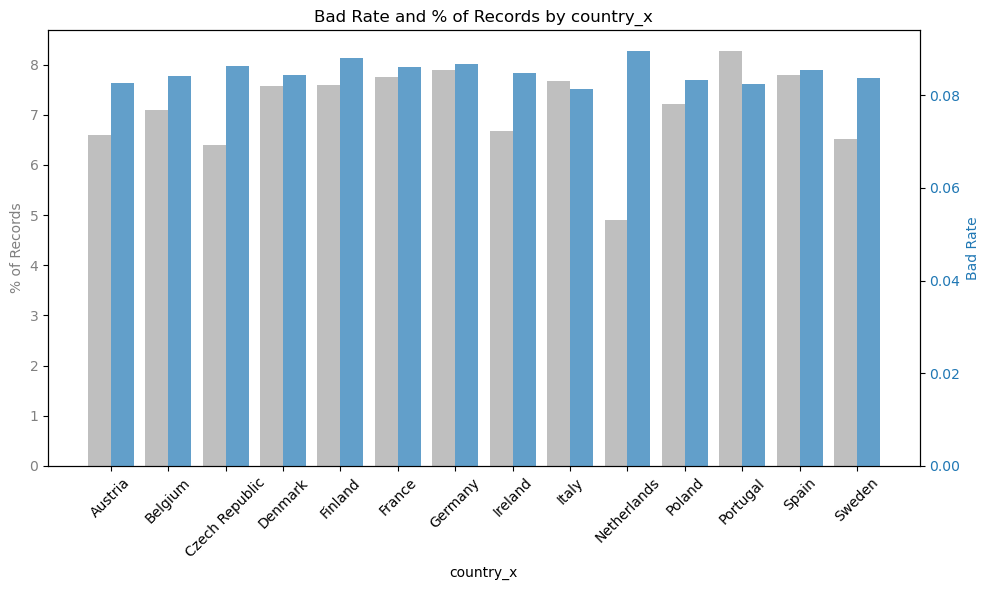

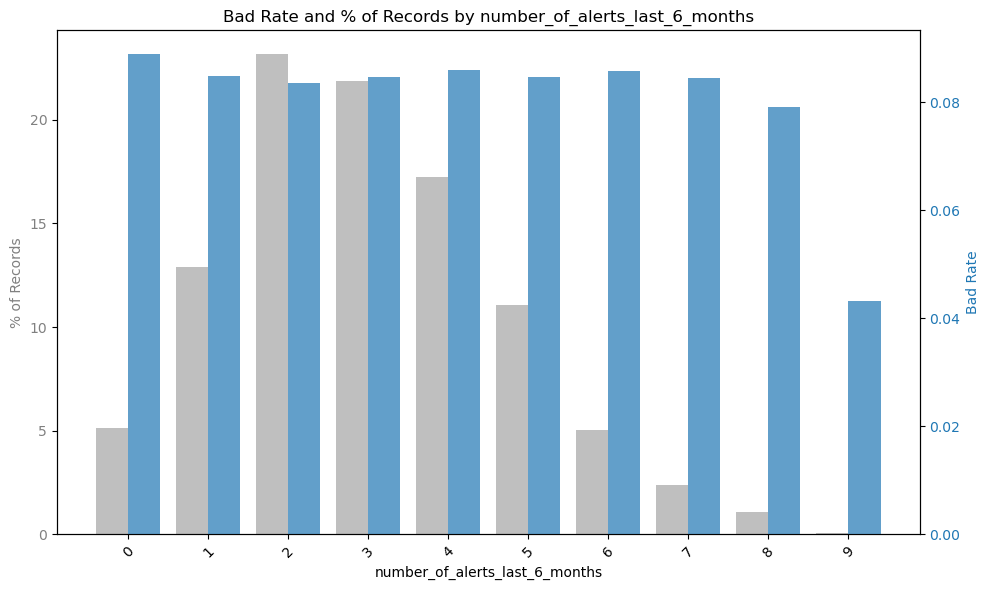

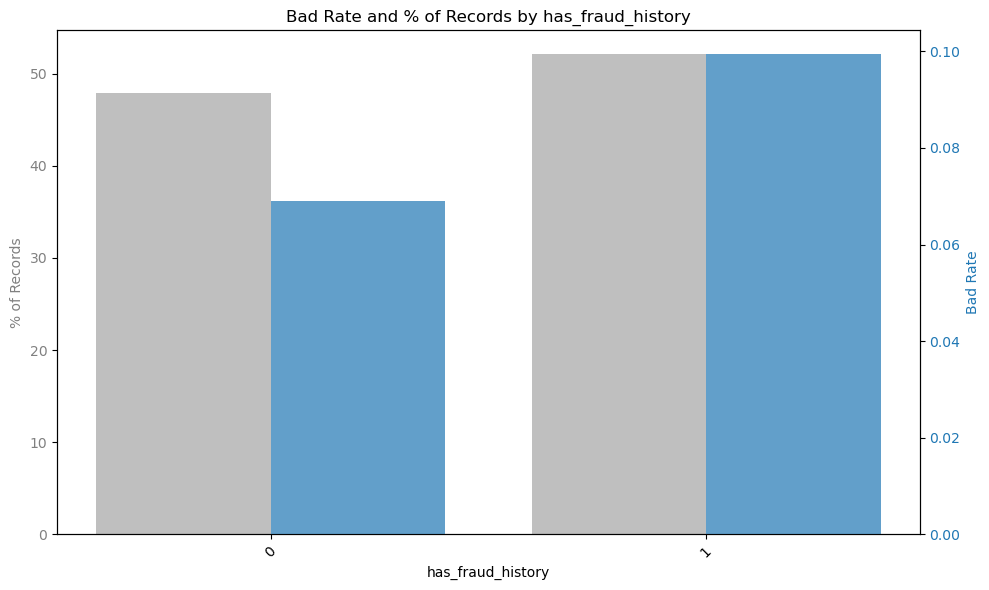

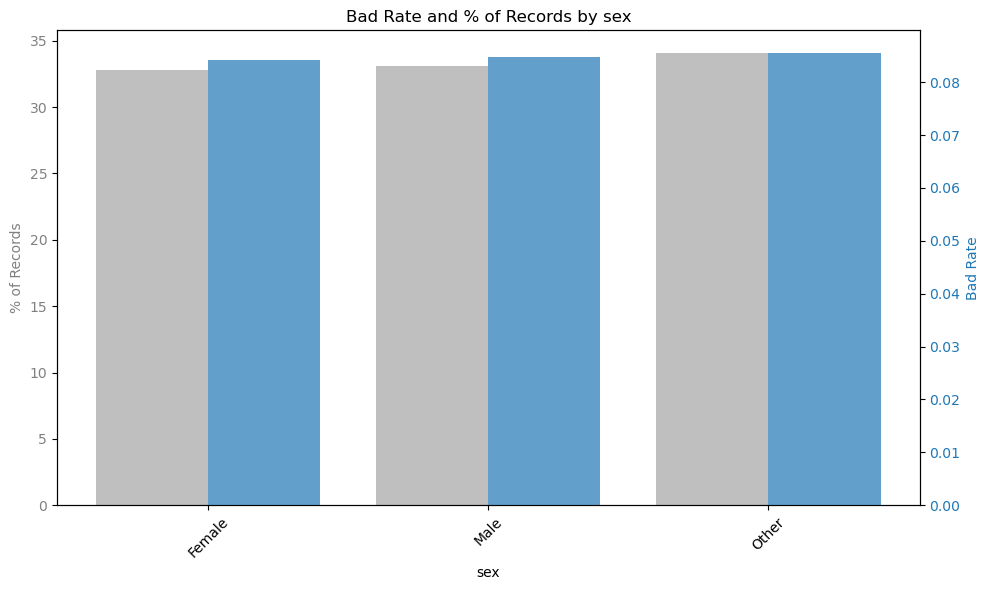

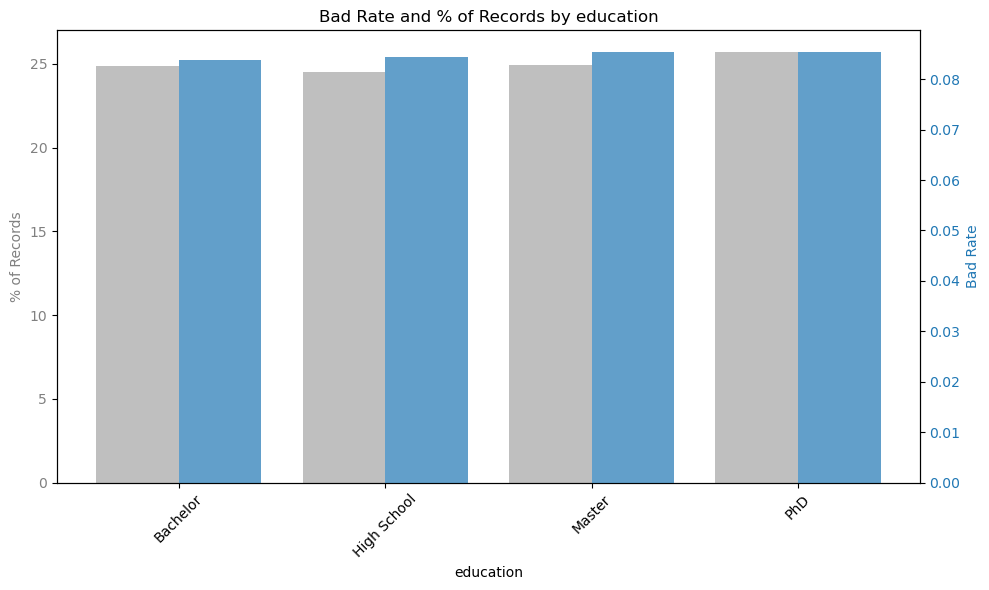

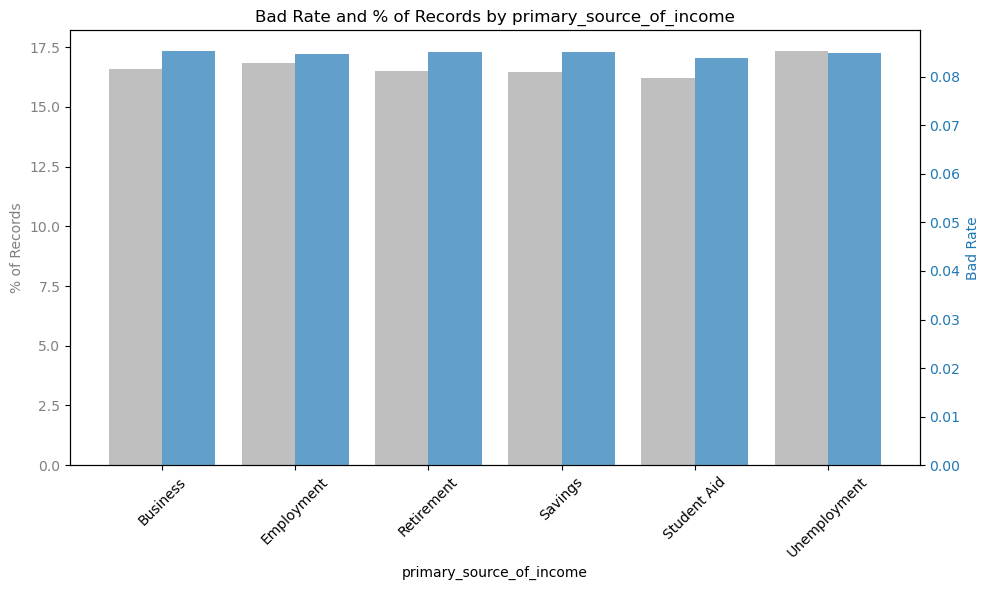

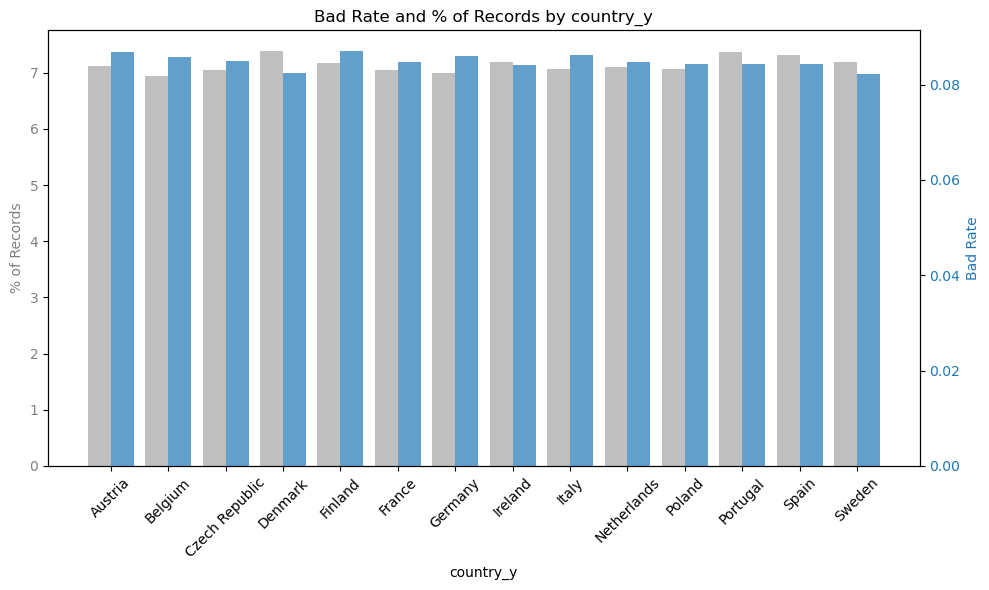

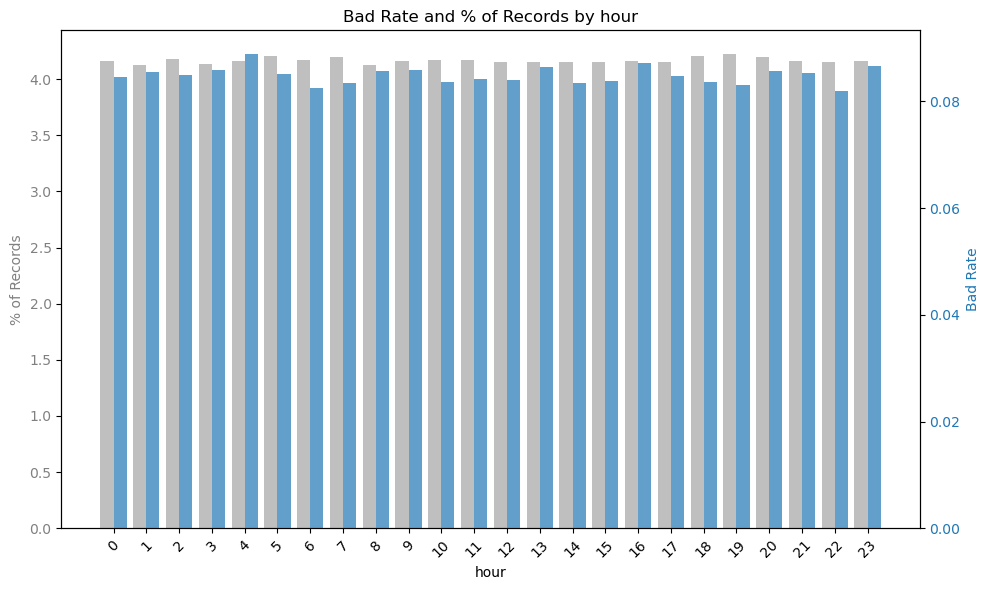

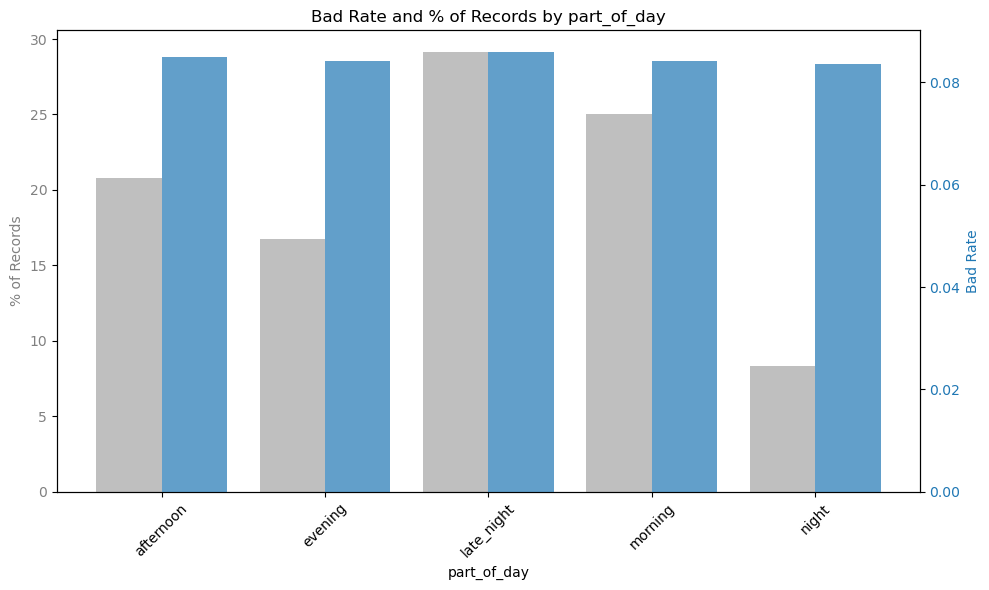

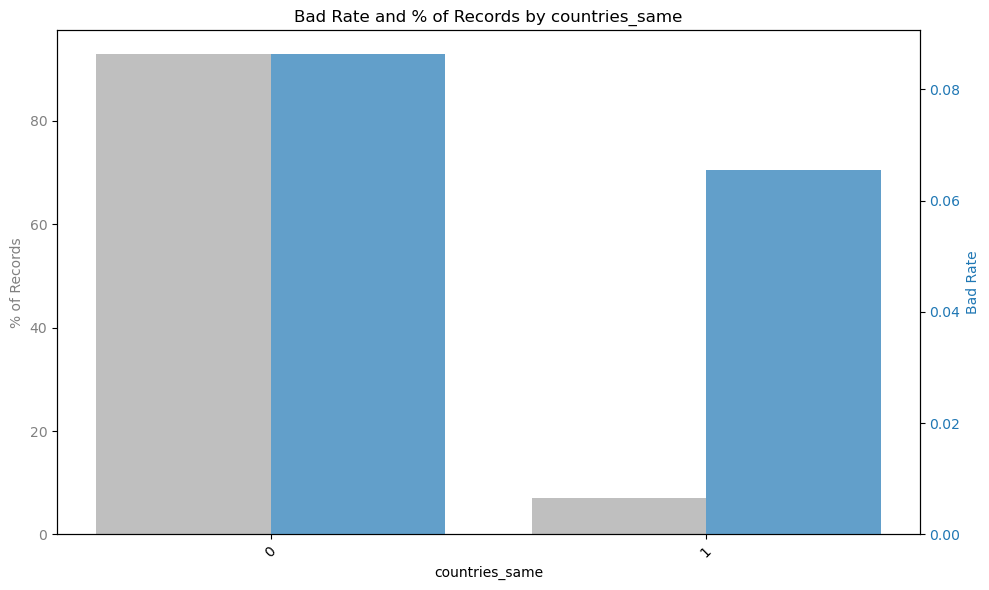

In [31]:
for driver in drivers:
    calculate_bad_percentage_with_plot(df, driver, 'is_fraud',)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_bad_rate_for_continuous(df, variable, target, bins=10, binning_method='quantile'):
    """
    Calculates bad rate by binning a continuous variable and plots a side-by-side bar chart
    with bad rate and percentage of records per bin.

    Parameters:
    - df: pandas DataFrame
    - variable: name of the continuous variable
    - target: name of the binary target (1 = bad, 0 = good)
    - bins: number of bins or list of bin edges
    - binning_method: 'quantile' or 'uniform'

    Returns:
    - summary DataFrame with bin, total, bads, bad_rate, and percent
    """
    if variable not in df.columns or target not in df.columns:
        raise ValueError(f"Columns '{variable}' or '{target}' not found in DataFrame.")

    df = df.copy()

    # Binning
    if binning_method == 'quantile':
        df['bin'] = pd.qcut(df[variable], q=bins, duplicates='drop')
    elif binning_method == 'uniform':
        df['bin'] = pd.cut(df[variable], bins=bins)
    else:
        raise ValueError("binning_method must be 'quantile' or 'uniform'.")

    # Aggregation
    grouped = df.groupby('bin', observed=True)[target].agg(['count', 'sum']).reset_index()
    grouped.rename(columns={'count': 'total', 'sum': 'bads'}, inplace=True)
    grouped['bad_rate'] = grouped['bads'] / grouped['total']
    grouped['percent'] = grouped['total'] / grouped['total'].sum() * 100

    # Plotting side-by-side bars
    labels = grouped['bin'].astype(str)
    x = np.arange(len(labels))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar 1: % of records (left axis)
    ax1.bar(x - width/2, grouped['percent'], width=width, color='gray', alpha=0.4, label='% of Records')
    ax1.set_ylabel('% of Records', color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # Bar 2: bad rate (right axis)
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, grouped['bad_rate'], width=width, color='tab:red', alpha=0.8, label='Bad Rate')
    ax2.set_ylabel('Bad Rate', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # X-axis formatting
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.set_xlabel(f'{variable} bins')

    # Title and layout
    plt.title(f'Bad Rate and % of Records by Binned {variable}')
    fig.tight_layout()
    plt.show()

    return grouped

In [36]:
drivers = [ 'amount', 'session_length_seconds', 'trust_score', 'avg_transaction_amount',  'account_age_months', 'age', 
                'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score', 'time_diff_hours', 'distance_km', 
            'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 
]

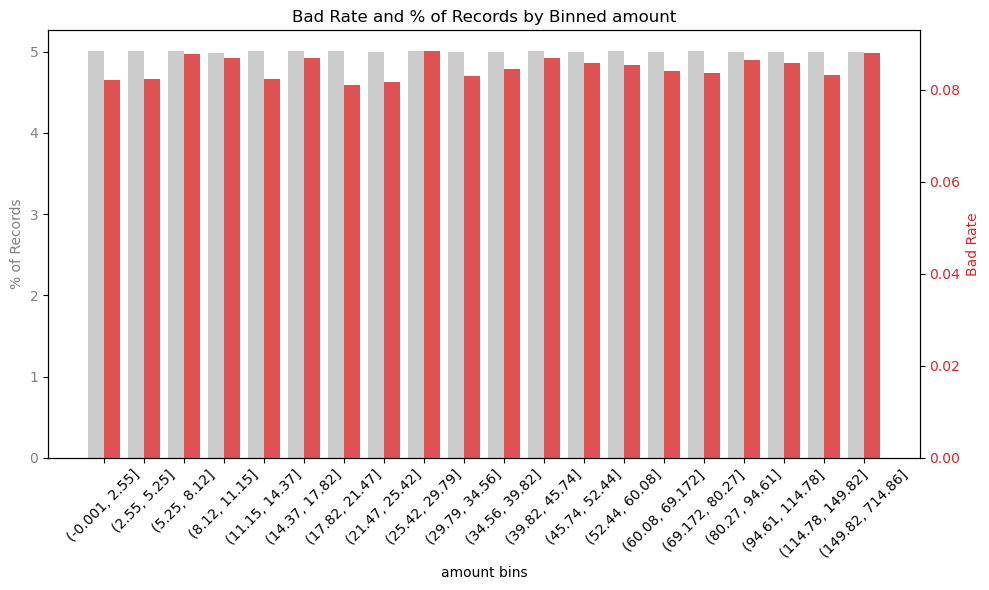

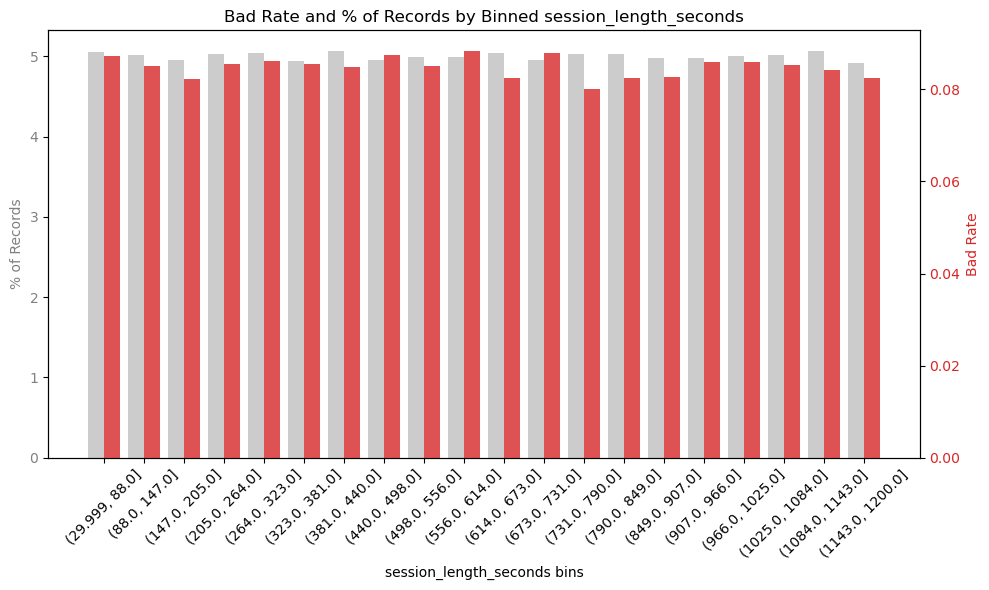

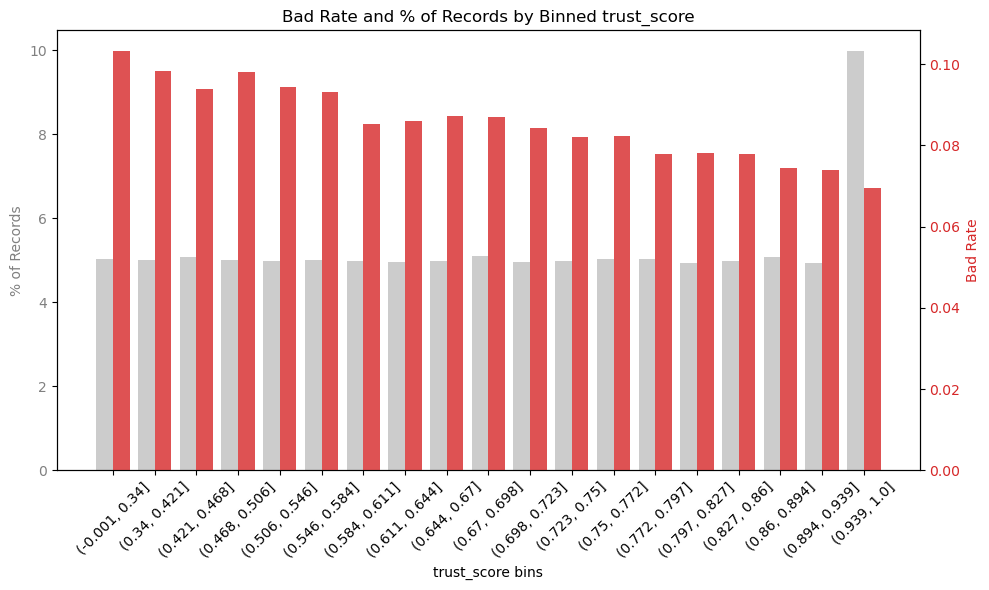

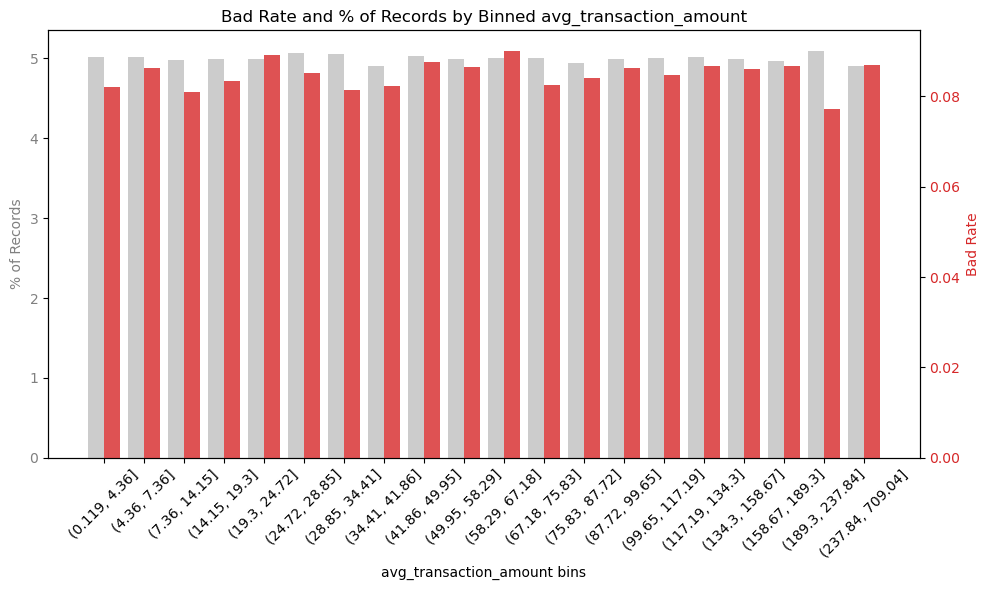

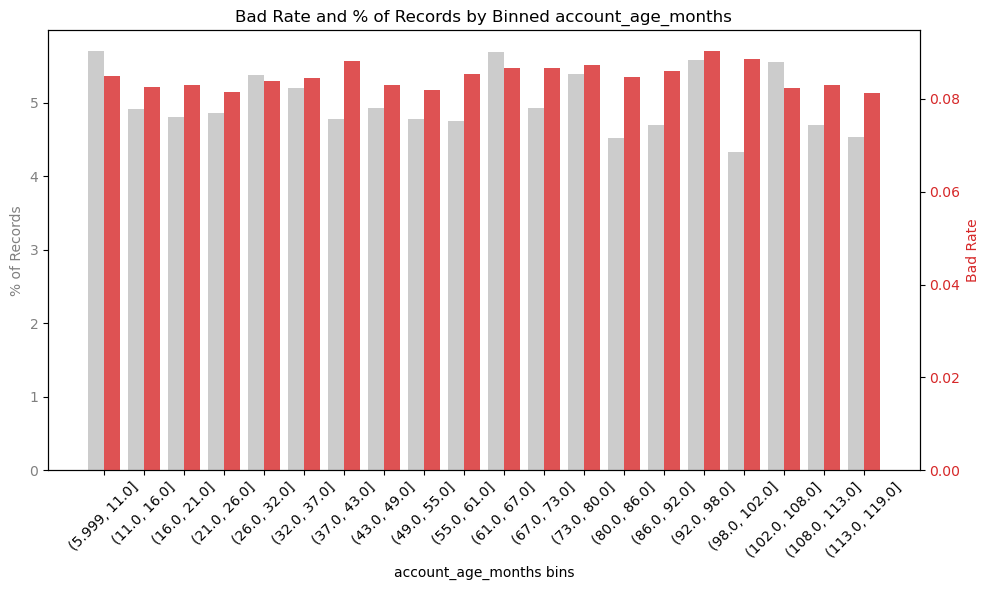

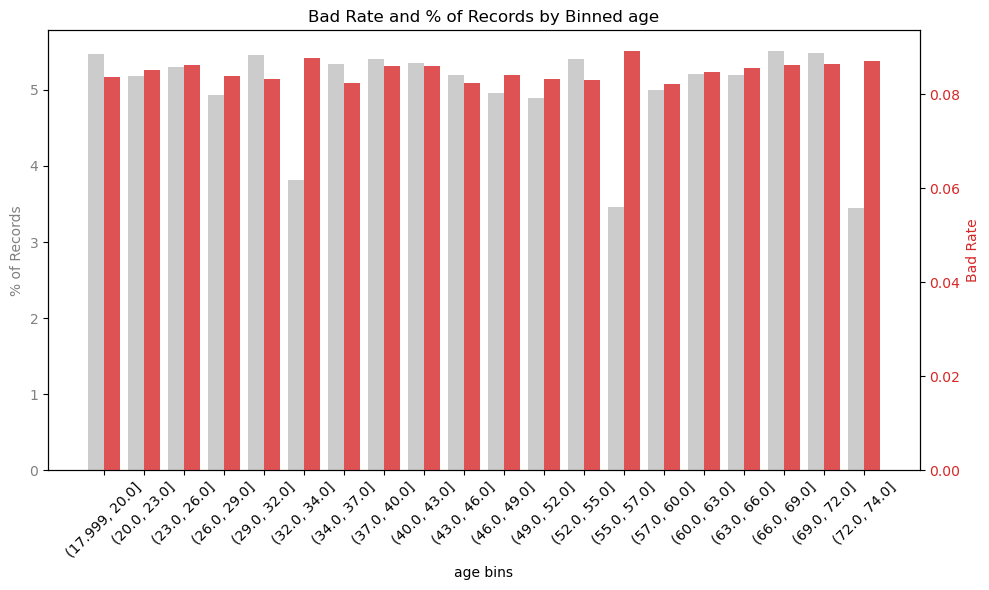

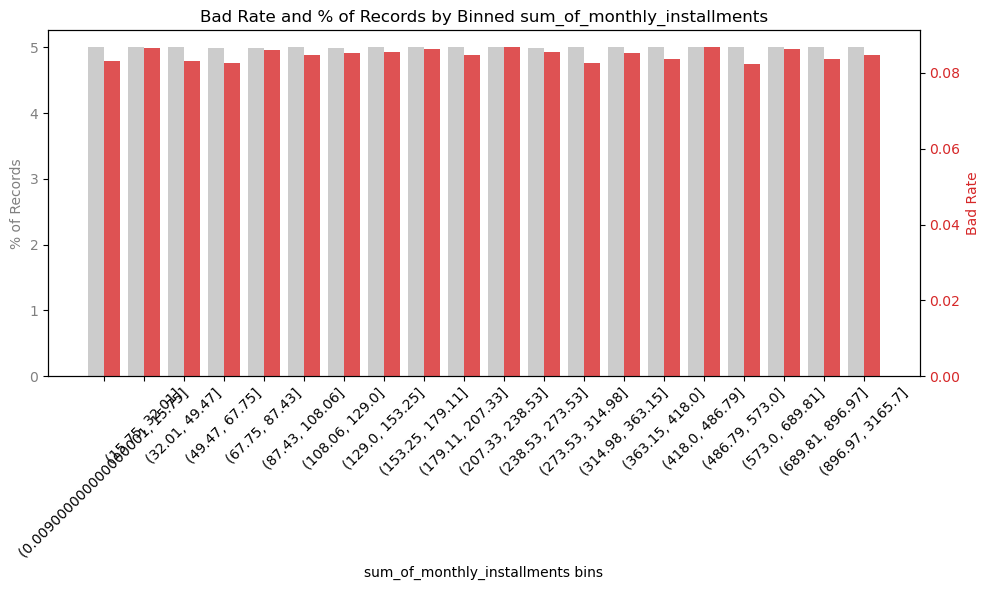

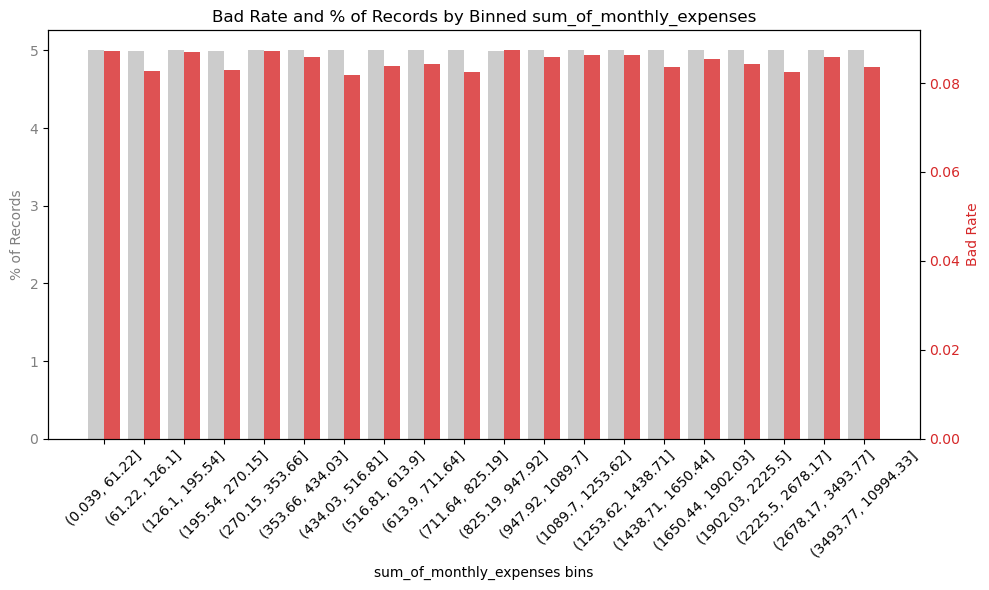

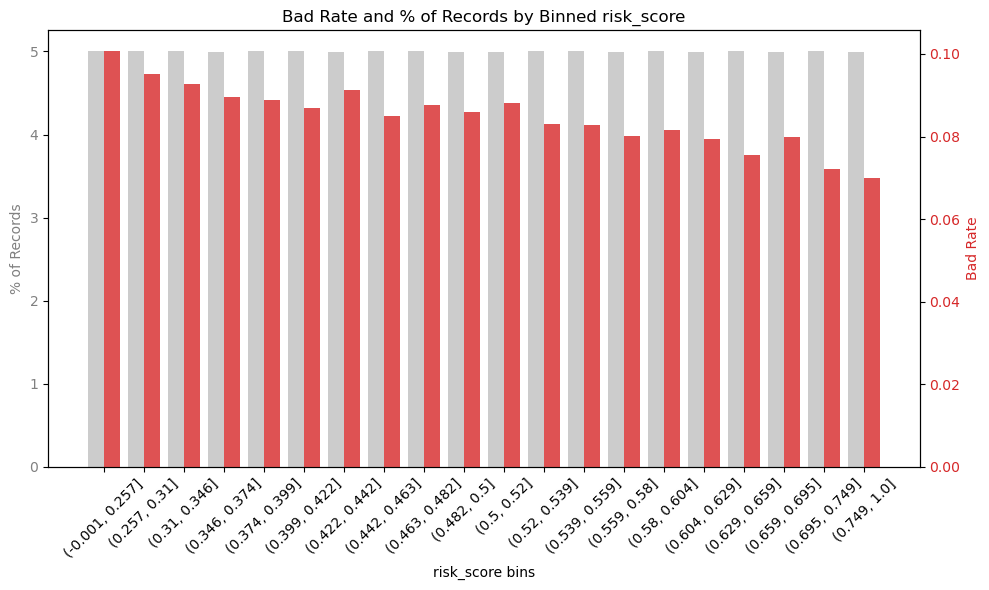

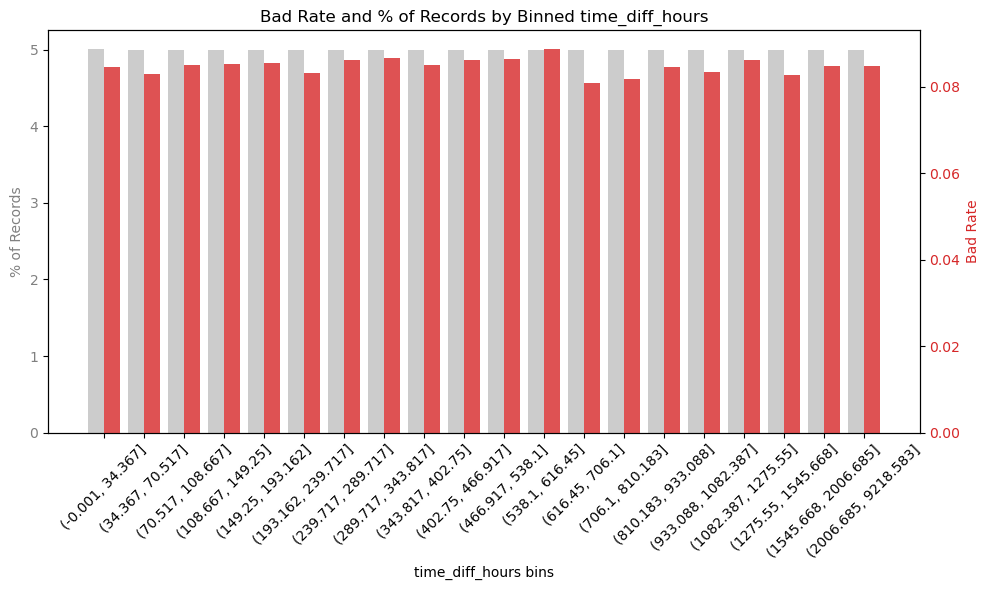

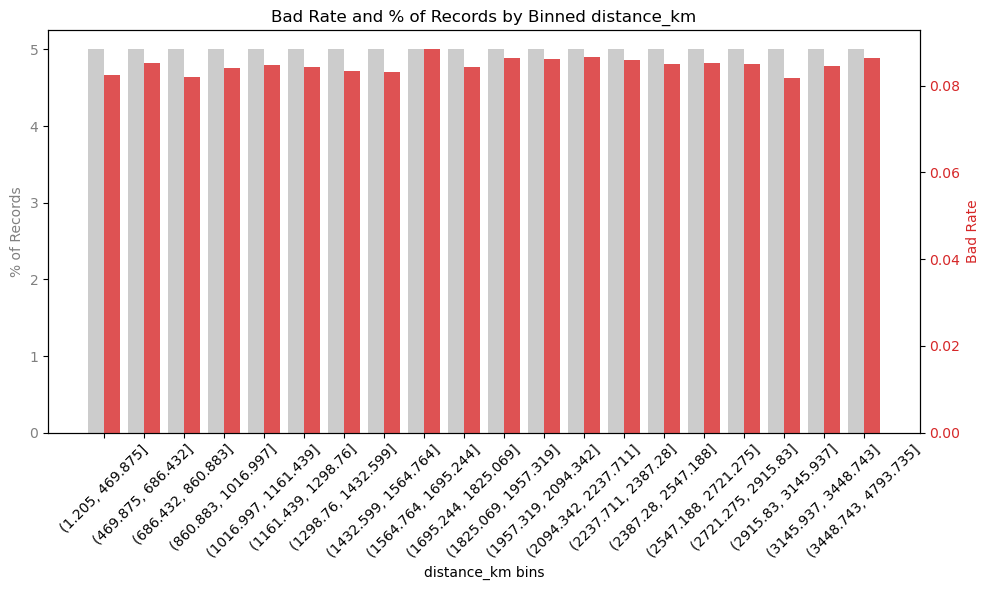

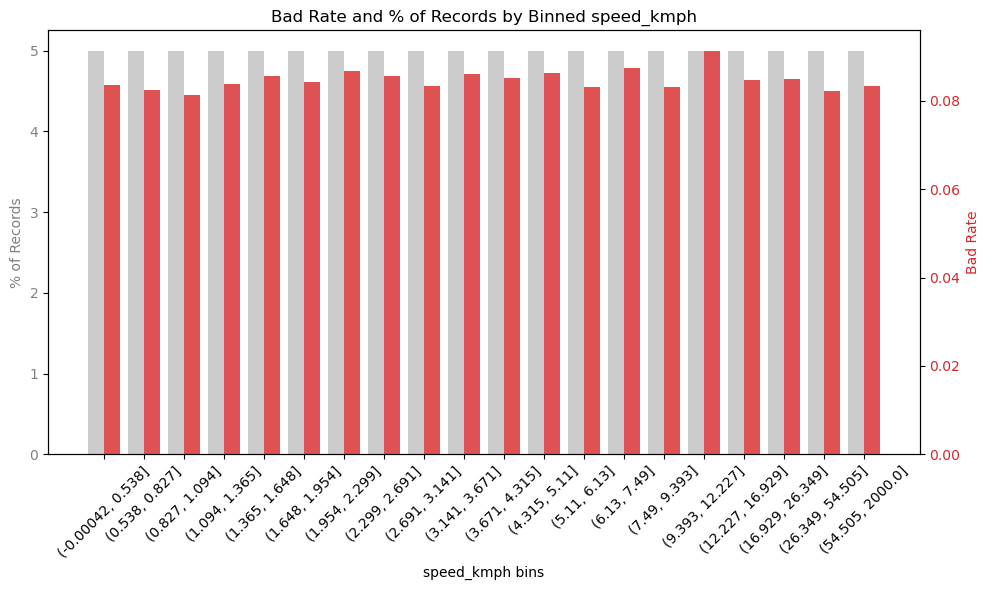

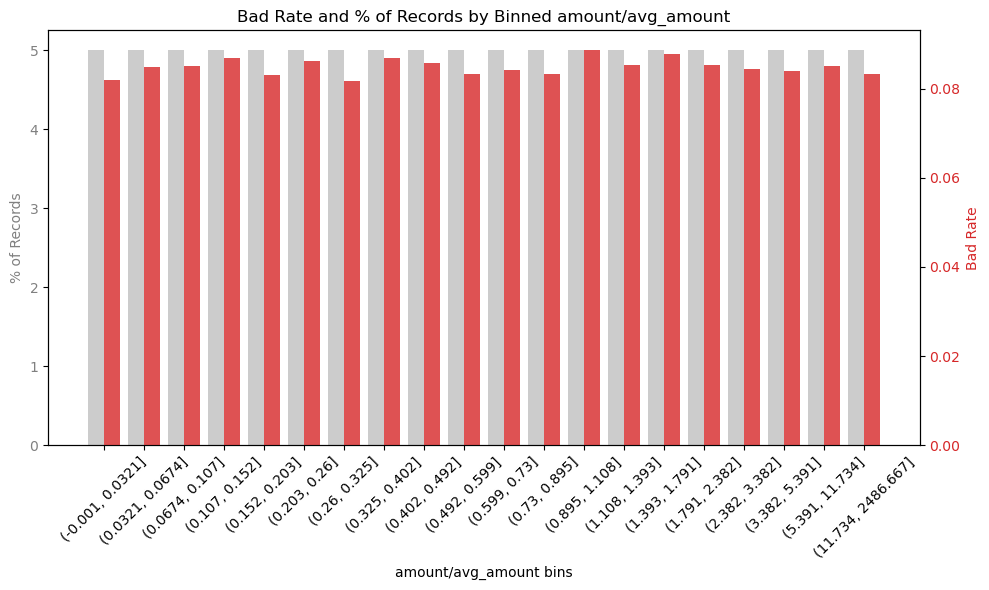

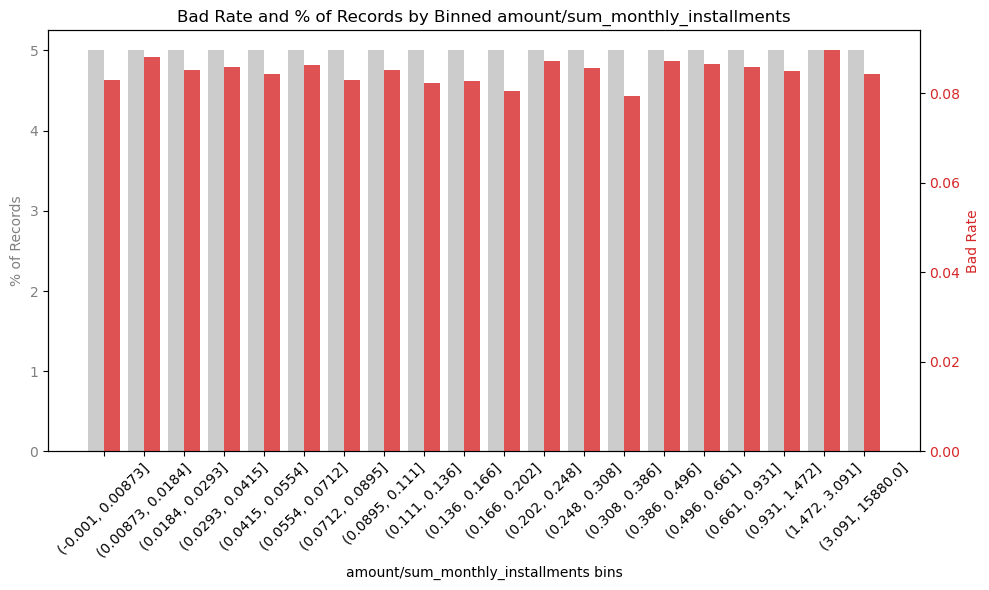

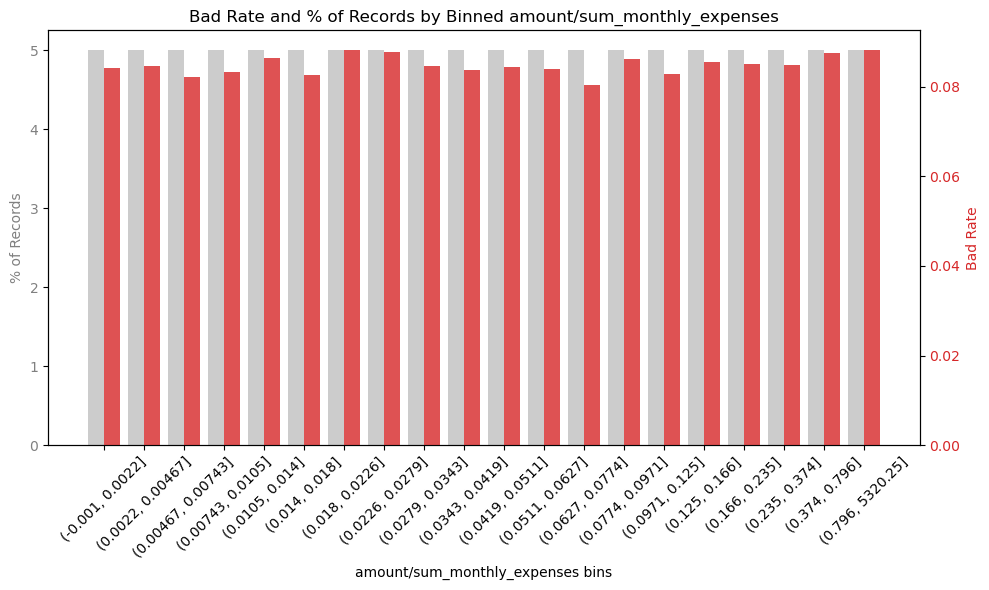

In [37]:
for driver in drivers:
    calculate_bad_rate_for_continuous(df, driver, 'is_fraud', bins=20)

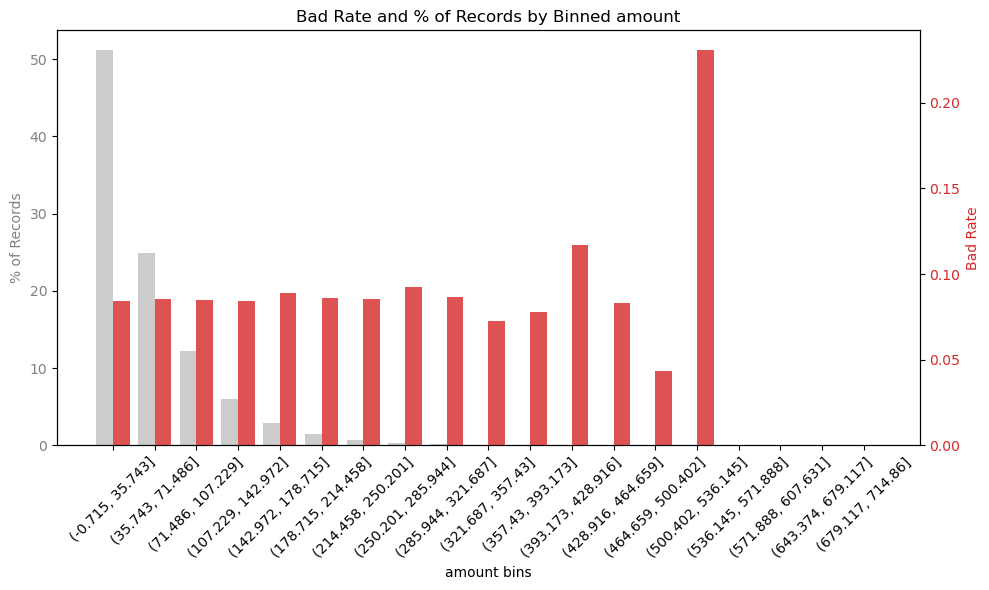

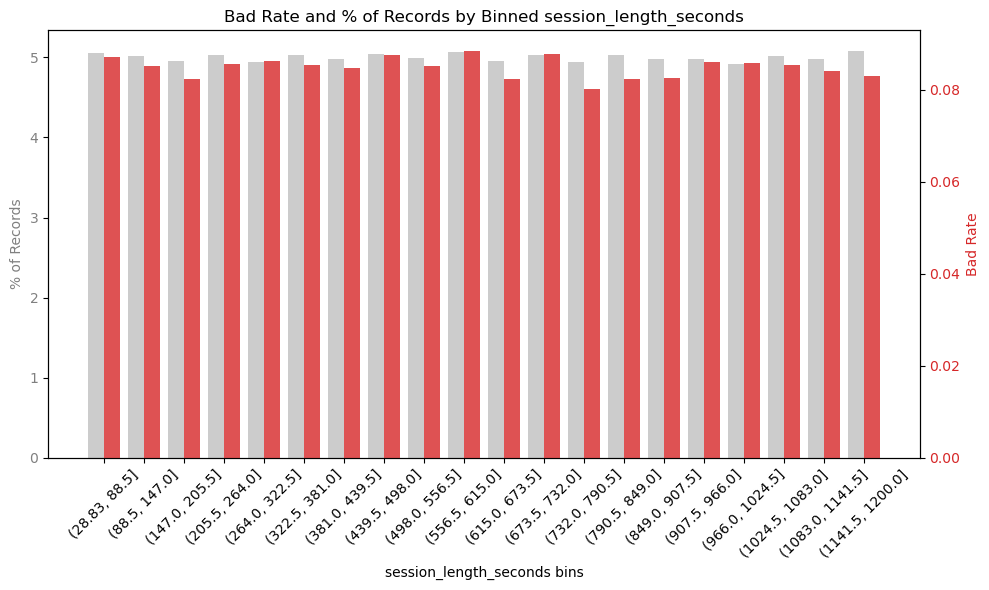

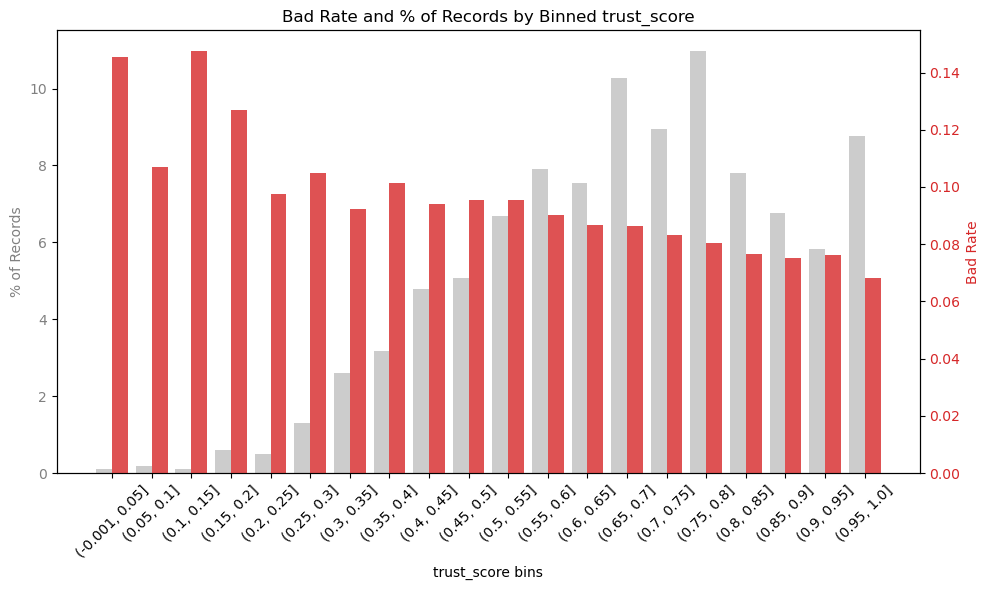

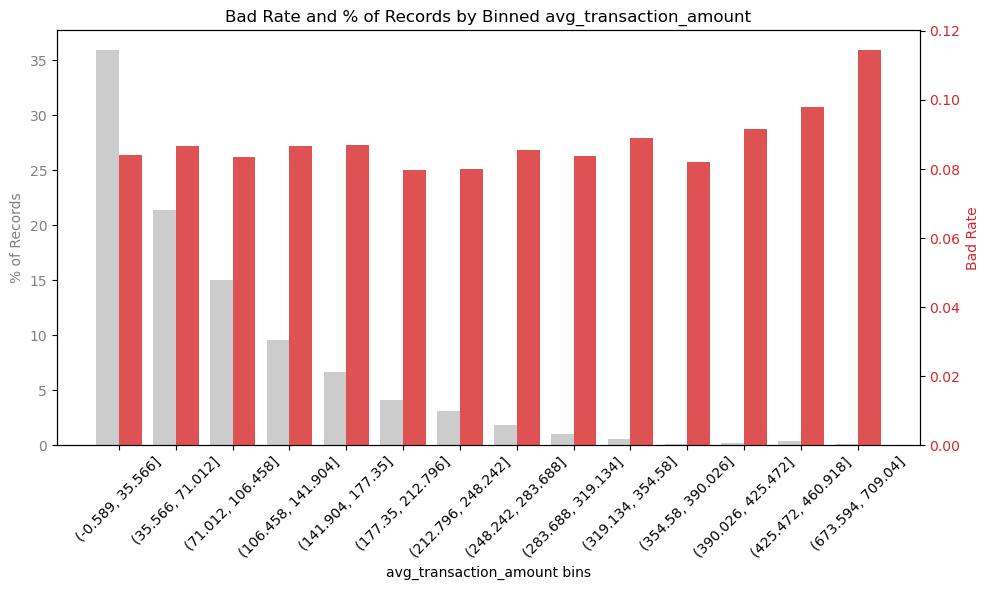

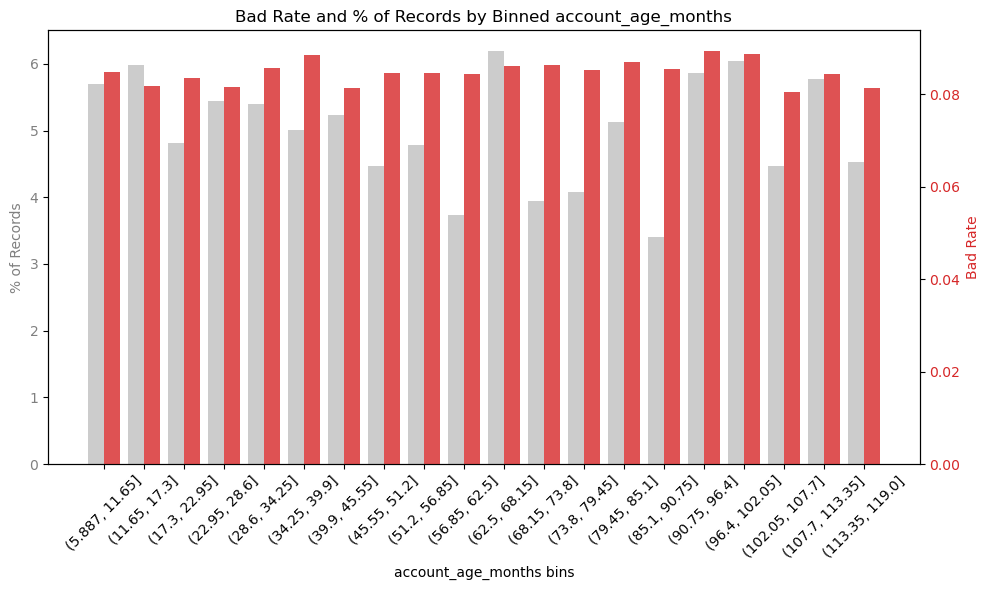

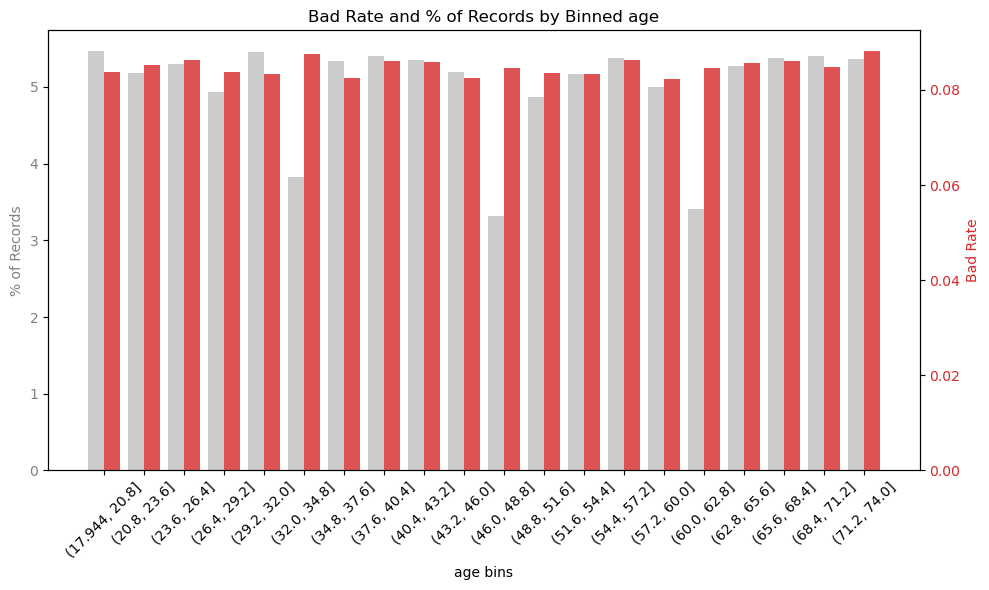

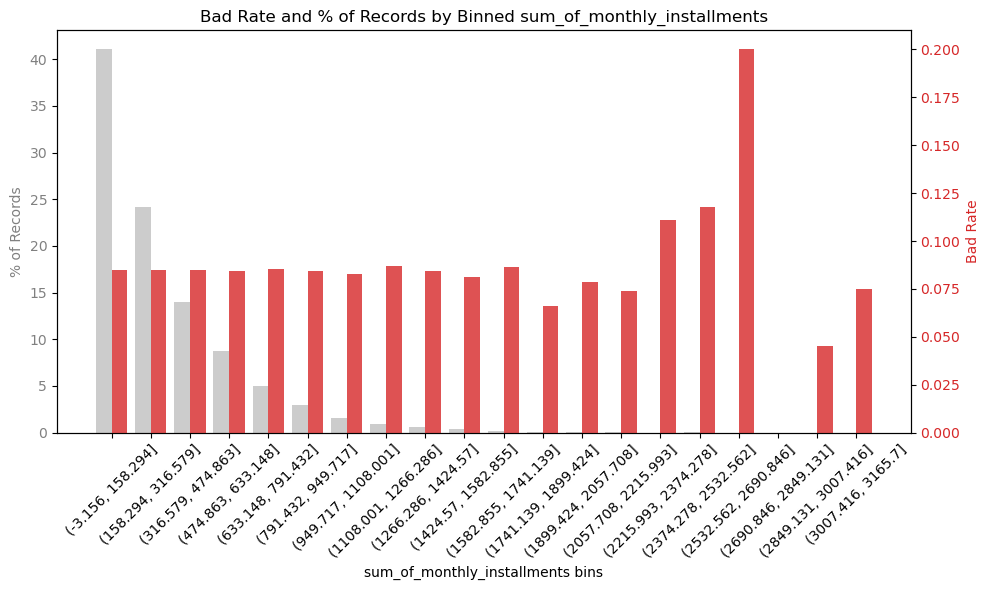

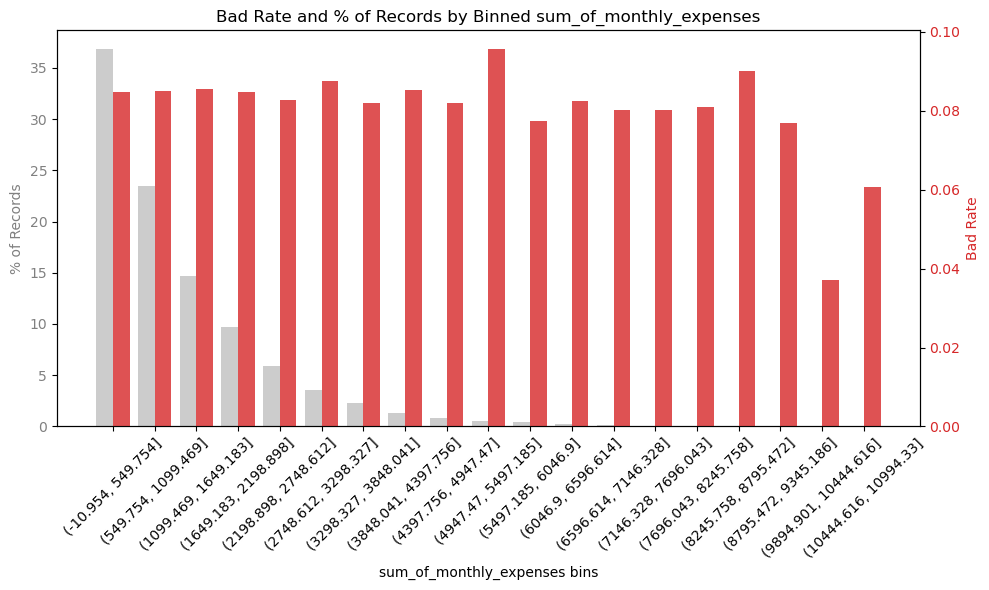

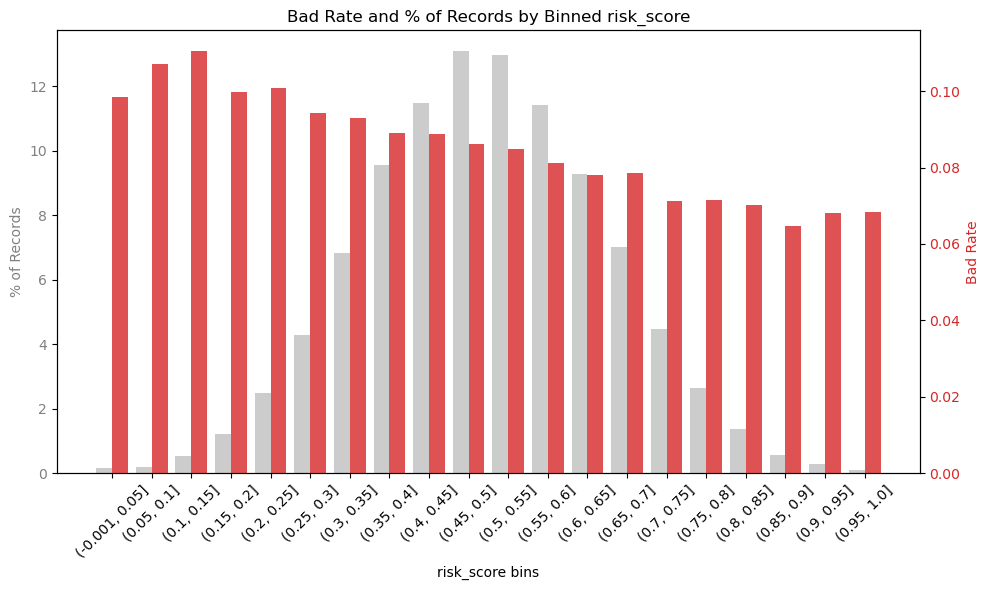

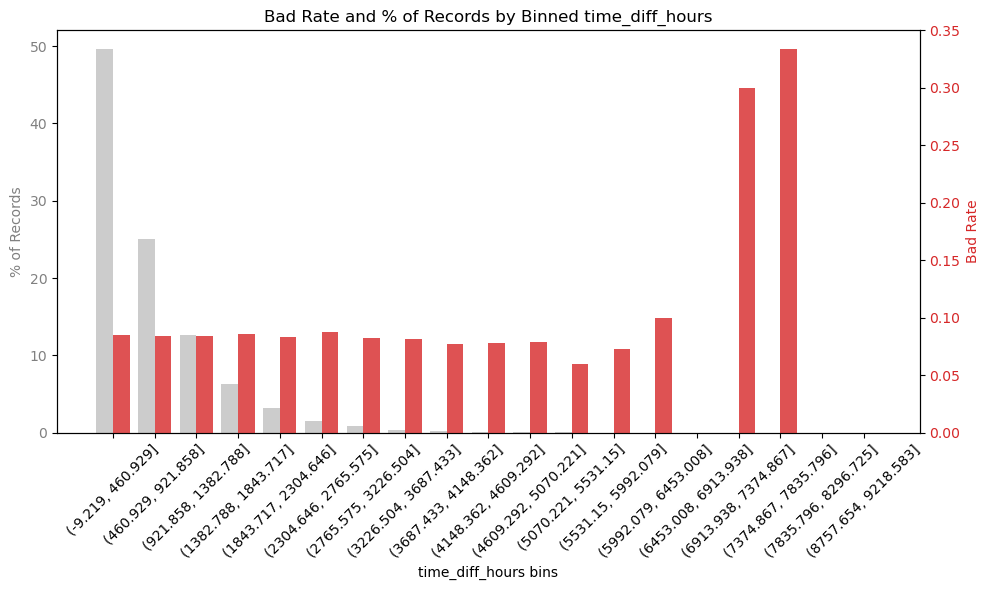

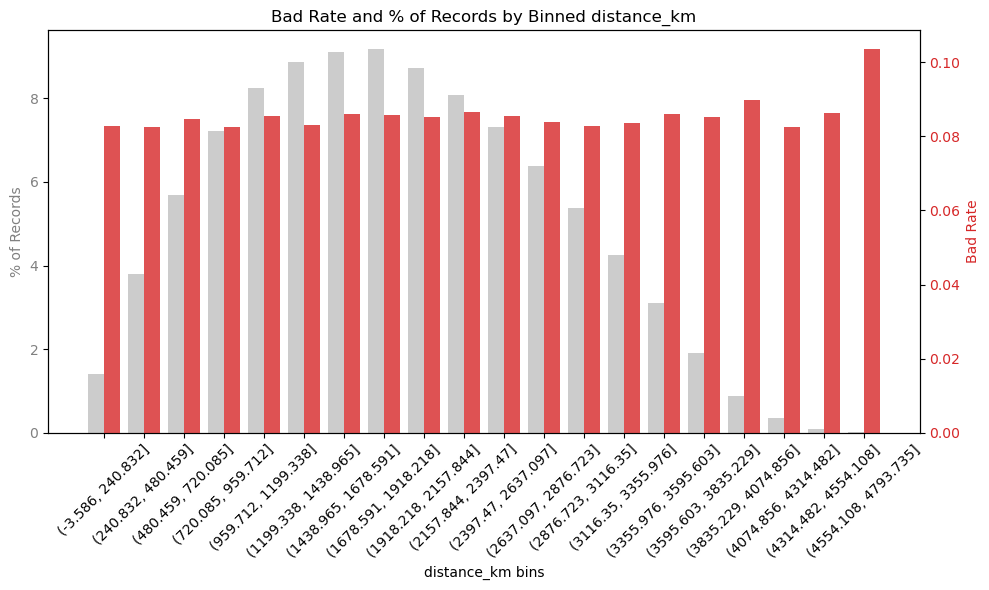

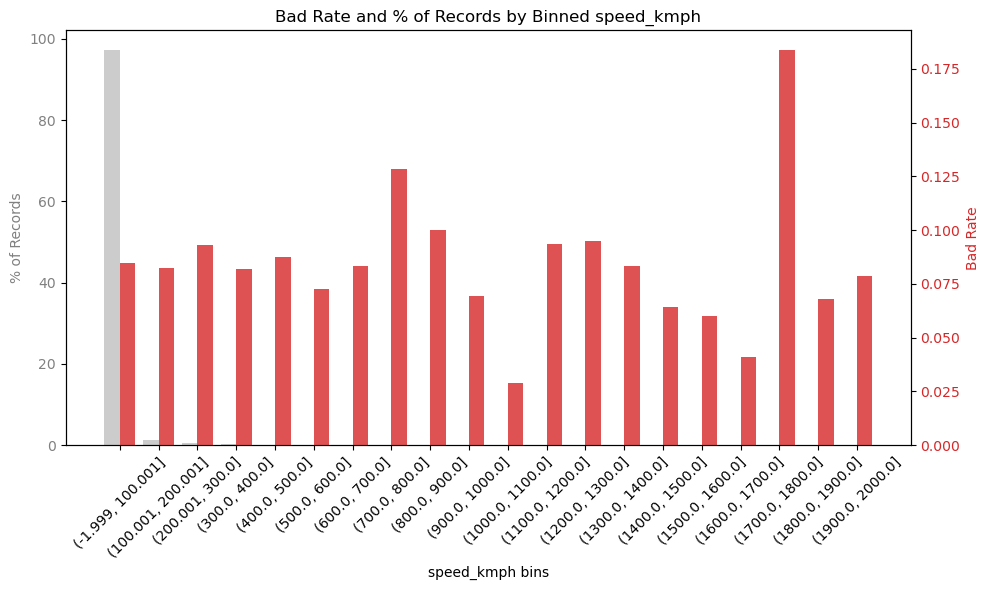

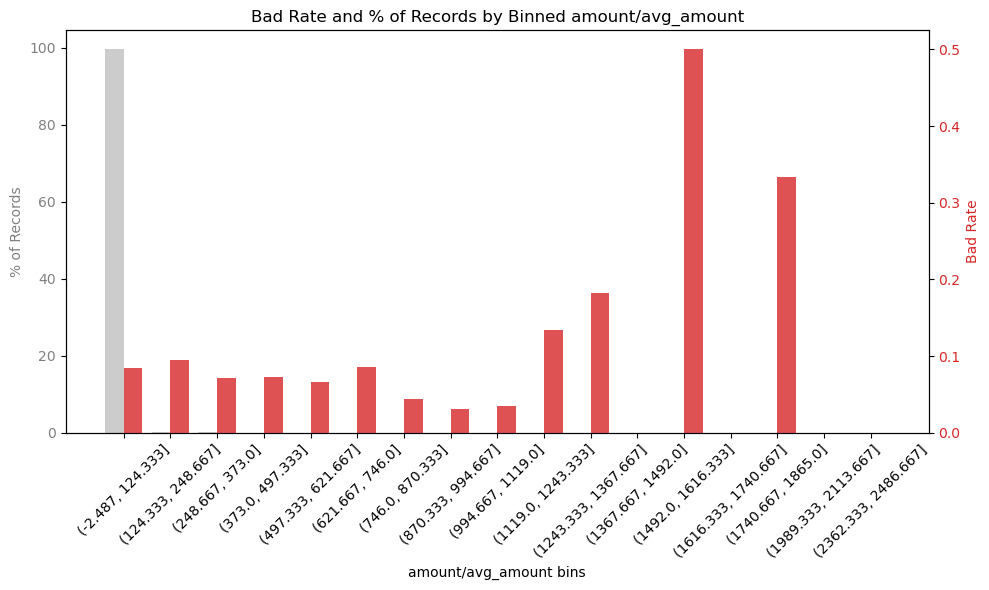

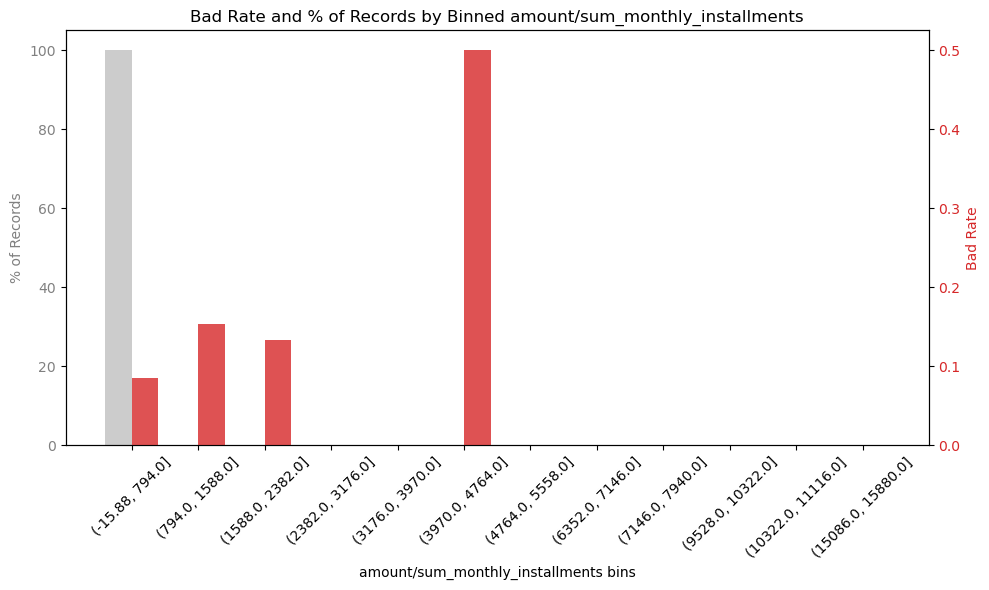

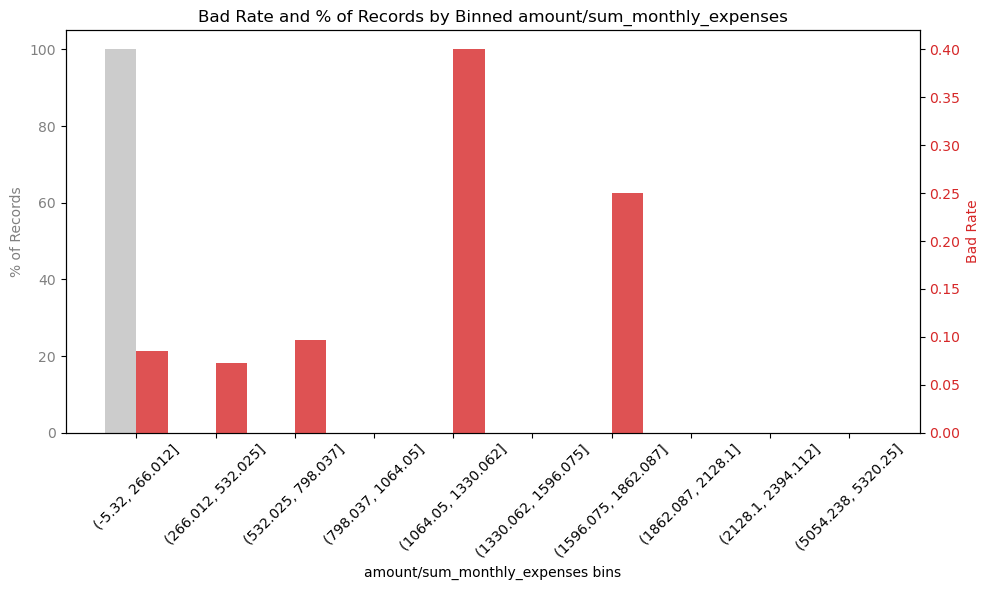

In [39]:
for driver in drivers:
    calculate_bad_rate_for_continuous(df, driver, 'is_fraud', bins=20, binning_method = 'uniform')